In [1]:
from snow import SnowModel
from seb import SebModel
from soil import SoilModel
from thermal import Thermal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
fforc = r'/Users/jpnousu/Documents/Forc_test/FORCING_LOMPOLO.nc'
forc = xr.open_dataset(fforc).sel(time=slice('2020-10-01', '2021-07-01'))

In [3]:
seb = SebModel()
snow = SnowModel()
soil = SoilModel()
thermal = Thermal()

In [4]:
dt = 3600
Ncnpy = 0
cveg = np.zeros(Ncnpy) 
Ds1 = np.array(5)
fcans = np.zeros(Ncnpy)
lveg = np.zeros(Ncnpy)
fsnow = np.zeros(1)
gs1 = np.zeros(1)
ks1 = np.zeros(1)
Sveg = np.zeros(1)
SWveg = np.zeros(1)
tdif = np.zeros(1)
Ts1 = np.zeros(1)
Tveg0 = np.zeros(1)
Ua = np.zeros(1)+0.1
VAI = np.zeros(1)
vegh = np.zeros(1)
zT = np.zeros(1)
zU = np.zeros(1)
Sice = np.ones(shape=3)
Sliq = np.ones(shape=3)
Tsoil = np.ones(3)+273.15
Tsnow = np.ones(3)+273.15
ksoil = np.ones(3)*0.24
Nsnow = np.zeros(1)
Rgrn = np.zeros(3)
Dsnw = np.zeros(3)
Vsmc = np.zeros(3)+0.3

# outputs
Tsoillist = []
swelist = []
hslist = []
Meltlist = []
Gsrflist = []

for i in range(len(forc['time'])):
    
    d_forc = forc.isel(time=i)
    print('step', i)

    LW = np.array(d_forc['LWdown'].data)
    Ps = np.array(d_forc['PSurf'].data)
    SWsrf = np.array(d_forc['DIR_SWdown'].data)
    Ta = np.array(d_forc['Tair'].data)
    Rf = np.array(d_forc['Rainf'].data)
    Sf = np.array(d_forc['Snowf'].data)
    Ua = np.array(d_forc['Wind'].data)
    Qa = np.array(d_forc['Qair'].data)

    Ds1, gs1, ks1, Ts1, csoil, ksnow, ksoil = thermal.run_timestep(Nsnow=Nsnow, Dsnw=Dsnw,
                                                                   Sice=Sice, Sliq=Sliq,
                                                                   Tsnow=Tsnow, Tsoil=Tsoil,
                                                                   Vsmc=Vsmc)

    Esrf, Gsrf, H, LE, LWout, LWsub, Melt, subl, Usub, Eveg, Tsrf = seb.run_timestep(cveg=cveg, Ds1=Ds1, 
                                                                                      dt=dt, fcans=fcans, 
                                                                                      fsnow=fsnow, gs1=gs1, 
                                                                                      ks1=ks1, lveg=lveg, LW=LW, 
                                                                                      Ps=Ps, Qa=Qa, SWsrf=SWsrf, 
                                                                                      Sveg=Sveg, SWveg=SWveg, 
                                                                                      Ta=Ta, tdif=tdif, Ts1=Ts1, 
                                                                                      Tveg0=Tveg0, Ua=Ua, VAI=VAI, 
                                                                                      vegh=vegh, zT=zT, zU=zU, Sice=Sice)
    
    Gsoil, Roff, hs, swe, Wflx, Sice, Sliq, Dsnw, Rgrn, Tsnow, Tsoil, Nsnow = snow.run_timestep(dt=dt, 
                                                                                                drip=0, 
                                                                                                Esrf=Esrf, 
                                                                                                Gsrf=Gsrf,
                                                                                                ksoil=ksoil, 
                                                                                                Melt=Melt, 
                                                                                                Rf=Rf, 
                                                                                                Sf=Sf, 
                                                                                                Ta=Ta, 
                                                                                                trans=0, 
                                                                                                Tsrf=Tsrf,
                                                                                                unload=0, 
                                                                                                Tsoil=Tsoil)

    Tsoil = soil.run_timestep(dt, Gsoil, csoil, ksoil, Tsoil)
    
    swelist.append(swe)
    hslist.append(hs)
    Meltlist.append(Melt)
    Gsrflist.append(Gsrf)
    Tsoillist.append(Tsoil[0])

step 0
ksnow [0.24 0.24 0.24]
ustar before [0.29311347]
rho [1.2542158]
wsrf 1
ga [0.02284678]
Qsrf [1.3312505e-18]
Qa [0.00743709]
Explicit fluxes, Esrf: [-0.00021311]
ne 5
abs(ebal) [5.91171556e-12]
initial self.Nsnow [0.]
initial self.Dsnw [0. 0. 0.]
initial self.Sice [0. 0. 0.]
initial self.Sliq [0. 0. 0.]
step 1
ksnow [0.24 0.24 0.24]
ustar before [0.2624388]
rho [1.2545196]
wsrf 1
ga [0.02137092]
Qsrf [3.38881407e-18]
Qa [0.00732347]
Explicit fluxes, Esrf: [-0.00019634]
ne 5
abs(ebal) [5.68434189e-14]
initial self.Nsnow 0
initial self.Dsnw [0. 0. 0.]
initial self.Sice [0. 0. 0.]
initial self.Sliq [0. 0. 0.]
step 2
ksnow [0.24 0.24 0.24]
ustar before [0.28800103]
rho [1.2555336]
wsrf 1
ga [0.0233428]
Qsrf [4.39017737e-18]
Qa [0.0071475]
Explicit fluxes, Esrf: [-0.00020948]
ne 5
abs(ebal) [0.]
initial self.Nsnow 0
initial self.Dsnw [0. 0. 0.]
initial self.Sice [0. 0. 0.]
initial self.Sliq [0. 0. 0.]
step 3
ksnow [0.24 0.24 0.24]
ustar before [0.31015497]
rho [1.2564708]
wsrf 1
ga [

/Users/jpnousu/pyFSM2/src/seb.py:528: RuntimeWarning: invalid value encountered in power
  2 * np.log((1 + (1 - 16 * zeta) ** 0.25) / 2) +
/Users/jpnousu/pyFSM2/src/seb.py:529: RuntimeWarning: invalid value encountered in sqrt
  np.log((1 + (1 - 16 * zeta) ** 0.5) / 2) -
/Users/jpnousu/pyFSM2/src/seb.py:530: RuntimeWarning: invalid value encountered in power
  2 * np.arctan((1 - 16 * zeta) ** 0.25) +
/Users/jpnousu/pyFSM2/src/seb.py:542: RuntimeWarning: invalid value encountered in sqrt
  2 * np.log((1 + (1 - 16 * zeta) ** 0.5) / 2))


ksnow [0.35463174 0.42116279 0.24      ]
ustar before [0.09202399]
rho [1.4253598]
wsrf 1
ga [0.00829625]
Qsrf [2.80249961e-19]
Qa [0.0005231]
Explicit fluxes, Esrf: [-6.18573946e-06]
ne 5
abs(ebal) [7.30082661e-12]
initial self.Nsnow 2
initial self.Dsnw [0.1       0.1446106 0.       ]
initial self.Sice [36.85268377 59.81539523  0.        ]
initial self.Sliq [0.90443462 0.         0.        ]
initial ksnow [0.24       0.42116279]
initial ksoil [1.0030962  0.96810968 0.80895363]
kold 0
knew 1
step 3267
ksnow [0.35452988 0.42112723 0.24      ]
ustar before [0.09884059]
rho [1.4291874]
wsrf 1
ga [0.00866252]
Qsrf [2.39013128e-19]
Qa [0.00049406]
Explicit fluxes, Esrf: [-6.11660085e-06]
ne 5
abs(ebal) [8.52651283e-13]
initial self.Nsnow 2
initial self.Dsnw [0.1        0.14468483 0.        ]
initial self.Sice [36.84760087 59.84341765  0.        ]
initial self.Sliq [0.90376377 0.         0.        ]
initial ksnow [0.24       0.42112723]
initial ksoil [1.00427    0.96910962 0.80907029]
kold 0

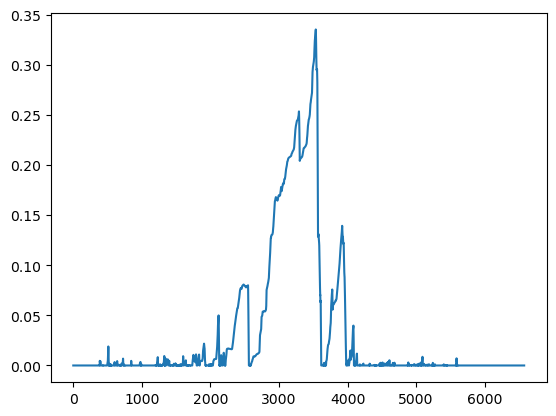

In [5]:
plt.plot(hslist)

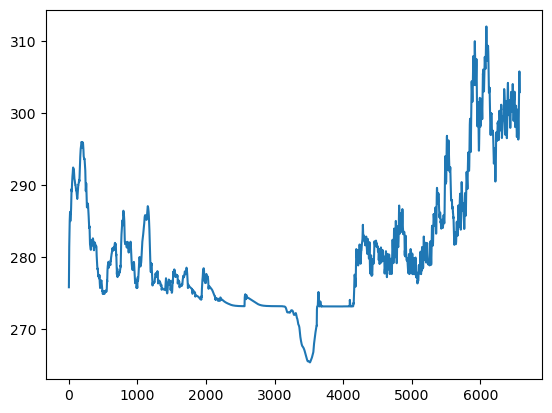

In [8]:
plt.plot(Tsoillist)